In [1]:
import os
import numpy as np
import pandas as pd
import p2pspatial
import pulse2percept.implants as p2pi
import pulse2percept.utils as p2pu
from pulse2percept.retina import dva2ret, ret2dva
import pyswarm

import sklearn.base as sklb

import matplotlib.pyplot as plt
%matplotlib inline

/home/mbeyeler/anaconda3/lib/python3.5/site-packages/skvideo/__init__.py:356: UserWarning: avconv/avprobe not found in path: 
  warnings.warn("avconv/avprobe not found in path: " + str(path), UserWarning)
2018-01-29 20:16:19,694 [pulse2percept] [INFO] Welcome to pulse2percept


In [2]:
use_trafo = False

In [3]:
subject = '52-001'
X, y = p2pspatial.load_data(os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape'), subject=subject,
                            amplitude=2.0, single_stim=True)
X.shape

(153, 9)

In [4]:
if use_trafo:
    trafo = p2pspatial.models.ModelB()
    
y_true = []
for _, row in y.iterrows():
    props = p2pspatial.imgproc.get_region_props(row['image'], thresh=0.1)
    x_center = props.centroid[1] / row['image'].shape[1] * 60 - 30
    y_center = props.centroid[0] / row['image'].shape[0] * 40 - 20
    if use_trafo:
        xy = trafo._displaces_rgc(np.array([[x_center, y_center]]))
        xy = (xy[0][0], xy[1][0])
    else:
        xy = (280*x_center, 280*y_center)
        xy = dva2ret((x_center, y_center))
    y_true.append({'x_center': xy[0], 'y_center': xy[1]})
y_true = pd.DataFrame(y_true, index=y.index)

In [5]:
electrodes = list(X.electrode.unique())

In [6]:
class ImplantPlacement(sklb.BaseEstimator):
    def __init__(self, x_center=0, y_center=0, rot=0):
        self.x_center = x_center
        self.y_center = y_center
        self.rot = rot
        self._is_fitted = False
        self.greater_is_better = False
    
    def get_params(self, deep=True):
        return {'x_center': self.x_center, 'y_center': self.y_center, 'rot': self.rot}
    
    def fit(self, X, y=None, **fit_params):
        self.set_params(**fit_params)
        self.implant = p2pi.ArgusII(x_center=self.x_center, y_center=self.y_center,
                                    rot=self.rot)
        self._is_fitted = True
        return self
    
    def predict(self, X):
        assert self._is_fitted
        y_pred = []
        for _, row in X.iterrows():
            ename = '%s%d' % (row['electrode'][0], int(row['electrode'][1:]))
            el = self.implant[ename]
            y_pred.append({'x_center': el.x_center, 'y_center': el.y_center})
        return pd.DataFrame(y_pred, index=X.index)
    
    def score(self, X, y, sample_weight=None):
        assert self._is_fitted
        y_pred = self.predict(X)
        err = [(yt[1]['x_center'] - yp[1]['x_center']) ** 2 + (yt[1]['y_center'] - yp[1]['y_center']) ** 2
               for yt, yp in zip(y.iterrows(), y_pred.iterrows())]
        return np.mean(err)

In [7]:
yy_true = pd.concat((X, y_true), axis=1).groupby('electrode', as_index=False).mean()

In [8]:
# argus = p2pi.ArgusII(x_center=-700, y_center=180, rot=-0.12345)
# for j in yy_true.index:
#     ename = '%s%d' % (yy_true.loc[j, 'electrode'][0], int(yy_true.loc[j, 'electrode'][1:]))
#     yy_true.loc[j, 'x_center'] = argus[ename].x_center
#     yy_true.loc[j, 'y_center'] = argus[ename].y_center

In [9]:
XX = yy_true

In [10]:
regressor = ImplantPlacement()

In [11]:
search_params = {'x_center': (-3000, 3000),
                 'y_center': (-2000, 2000),
                 'rot': (np.deg2rad(-90), np.deg2rad(90))}
pso_options = {'max_iter': 100,
               'min_func': 0.01}

In [12]:
pso = p2pspatial.model_selection.ParticleSwarmOptimizer(
    regressor, search_params, **pso_options
)

In [13]:
pso.fit(XX, yy_true)

No constraints given.
New best for swarm at iteration 1: [ -5.23592422e-02  -2.17041308e+03   1.17902346e+03] 1466689.8408989657
Best after iteration 1: [ -5.23592422e-02  -2.17041308e+03   1.17902346e+03] 1466689.8408989657
Best after iteration 2: [ -5.23592422e-02  -2.17041308e+03   1.17902346e+03] 1466689.8408989657
New best for swarm at iteration 3: [ -1.71631139e-01  -1.97029669e+03   1.03399197e+03] 1421884.750853026
New best for swarm at iteration 3: [ -5.28575263e-01  -1.88068929e+03   2.00000000e+03] 891346.9797574575
Best after iteration 3: [ -5.28575263e-01  -1.88068929e+03   2.00000000e+03] 891346.9797574575
New best for swarm at iteration 4: [ -3.30418017e-01  -2.01022803e+03   1.54619598e+03] 843310.1529101671
Best after iteration 4: [ -3.30418017e-01  -2.01022803e+03   1.54619598e+03] 843310.1529101671
New best for swarm at iteration 5: [ -3.47558540e-01  -2.16686997e+03   1.62702266e+03] 825892.1954887894
Best after iteration 5: [ -3.47558540e-01  -2.16686997e+03   1.62

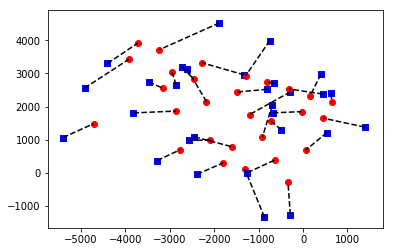

In [14]:
for (_, yt), (_, yp) in zip(yy_true.iterrows(), pso.predict(XX).iterrows()):
    plt.scatter(yt['x_center'], yt['y_center'], c='b', marker='s')
    plt.scatter(yp['x_center'], yp['y_center'], c='r', marker='o')
    plt.plot([yt['x_center'], yp['x_center']], [yt['y_center'], yp['y_center']], 'k--')

In [15]:
# 280*dva: 863413
# dva2ret: 773831
# prtrafo: 907130

In [16]:
folder = os.path.join(os.environ['SECOND_SIGHT_DATA'], 'shape', 'TB')
X, y = p2pspatial.load_data(folder, subject='TB')
X.shape

UnicodeDecodeError: 'utf-8' codec can't decode byte 0xd0 in position 0: invalid continuation byte

In [ ]:
import glob

In [ ]:
search_pattern = os.path.join(folder, '**', '*_VIDFileList_*')

In [ ]:
list(glob.iglob(search_pattern, recursive=True))